<a href="https://colab.research.google.com/github/Tasfia48/CS-687/blob/main/project_RandomASsignmentW_O_Constraint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Load data

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/github_OOSProbs_dat_0601520_withID_withSensitiveFeatures.csv')

#Preprocessing data

In [ ]:
df=df.drop(columns='Unnamed: 0')
bins = [0,18, 30, 40, 50, 60, 70, 120]
labels = ['0-18','18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df['AgeRange'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
df['Children'] = df['Children'].mask(df['Children'] > 1, 1)
df['PrimaryRace'] = df['PrimaryRace'].mask(df['PrimaryRace'] < 5, 3)
df['PrimaryRace'] = df['PrimaryRace'].mask(df['PrimaryRace'] > 7, 8)
df['Ethnicity'] = df['Ethnicity'].mask(df['Ethnicity'] > 0, 1)

In [ ]:
import random
foo = df.Original.unique().tolist()
temp = [random.randrange(0, 4, 1) for i in range(len(df))]
df['random'] = temp

In [ ]:
P_rand=[]
for ind,row in df.iterrows():
  temp=row['random']
  if temp==0:
    P_rand.append(row['ES'])
  elif temp==1:
    P_rand.append(row['Prev']) 
  elif temp==2:
    P_rand.append(row['RRH'])        
  else:
    P_rand.append(row['TH'])  

df['P_random'] = P_rand    

In [ ]:
# Functions for estimating equitability and improvement
def estimate_equitability(data,P):
  equitibility=[]
  improvment =[]
  for ind,row in data.iterrows():
    mi=min(row[['ES','TH',	'RRH','Prev']])
    e = row[P]/mi
    ma=max(row[['ES','TH',	'RRH','Prev']])
    i = ma-row[P]
    equitibility.append(e)
    improvment.append(i)
  return equitibility,improvment  

def create_group_df(df,x):
  temp=df.groupby(by=x).mean().reset_index()
  tempImprov = temp[[ x,'Improvement_true','Improvement_random', 
        'Improvement_optimal', 'Improvement_constraint','Equitability_true','Equitability_random','Equitability_optimal','Equitability_constraint']]
  return tempImprov      

def find_allocation(temp1,P_col_name):
  P_rand=[]
  for ind,row in temp1.iterrows():
    temp=row[P_col_name]
    if temp==row['ES']:
      P_rand.append("ES")
    elif temp==row['Prev']:
      P_rand.append('Prev') 
    elif temp==row['RRH']:
      P_rand.append('RRH')        
    else:
      P_rand.append('TH') 
  return P_rand     

### Random Allocation

In [ ]:
el,im = estimate_equitability(df,'P_random')
df['Equitability_random'] = el
df['Improvement_random'] = im

### Original Allocation

In [ ]:
allocation =[]
for ind,row in df.iterrows():
  temp=row['Original']
  allocation.append(row[temp])
df['P_true']=allocation  

In [ ]:
el,im = estimate_equitability(df,'P_true')
df['Equitability_true'] = el
df['Improvement_true'] = im

In [ ]:
A = df[['ES', 'Prev', 'RRH', 'TH']].values
model = ConcreteModel()
model.Agents = range(len(A))
model.Objects = range(len(A.T))
model.x = Var( model.Agents, model.Objects,bounds=(0.0,1.0) )
model.y = Var( model.Agents, within=Binary )

#Objective
model.obj = Objective(expr = sum(A[n,m]*model.x[n,m] for n in model.Agents for m in model.Objects),sense=minimize )

###Constraints
model.single_x = ConstraintList()
for m in model.Objects:
  model.single_x.add(sum( model.x[n,m] for n in model.Agents ) >=1 )

for m in model.Agents:
  model.single_x.add(sum( model.x[m,n] for n in model.Objects ) == 1.0 )

# create a solver
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

# solve
solver.solve(model)
a=dict()
for n in model.Agents:
  a[n]= []
  for m in model.Objects:
    a[n].append(value(model.x[n,m])*A[n,m]) 

In [ ]:
cost_mat = pd.DataFrame.from_dict(a).T
df['P_optimal'] = cost_mat[[0, 1,2,3]].max(axis=1)
df['ProOptimal'] = cost_mat[[0, 1,2,3]].idxmax(axis=1)

In [ ]:
eq1,im1=estimate_equitability(df,'P_optimal')
df['Equitability_optimal'] = eq1
df['Improvement_optimal'] = im1

In [ ]:
temp=df.groupby('Original').count()
Capacity=temp.Outcome.unique()
temp

,HouseholdIdentificationNumber,PrimaryRace,Ethnicity,DisablingCondition,VeteranStatus,Children,Age,SpousePresent,Gender,ES,TH,RRH,Prev,Outcome,AgeRange,random,P_random,Equitability_random,Improvement_random,P_true,Equitability_true,Improvement_true,P_optimal,ProOptimal,Equitability_optimal,Improvement_optimal
Original,,,,,,,,,,,,,,,,,,,,,,,,,,
ES,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441,4441
Prev,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202,6202
RRH,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846,846
TH,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451,2451


In [ ]:
A = df[['ES', 'Prev', 'RRH', 'TH']].values
model = ConcreteModel()
model.Agents = range(len(A))
model.Objects = range(len(A.T))
model.x = Var( model.Agents, model.Objects,bounds=(0.0,1.0) )
model.y = Var( model.Agents, within=Binary )

#Objective
model.obj = Objective(expr = sum(A[n,m]*model.x[n,m] for n in model.Agents for m in model.Objects),sense=minimize )

###Constraints
model.single_x = ConstraintList()
for m in model.Objects:
  model.single_x.add(sum( model.x[n,m] for n in model.Agents ) ==Capacity[m] )

for m in model.Agents:
  model.single_x.add(sum( model.x[m,n] for n in model.Objects ) == 1.0 )

# create a solver
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

# solve
solver.solve(model)
a=dict()
for n in model.Agents:
  a[n]= []
  for m in model.Objects:
    a[n].append(value(model.x[n,m])*A[n,m]) 

In [ ]:
cost_mat = pd.DataFrame.from_dict(a).T
df['P_OptimalConst'] = cost_mat[[0, 1,2,3]].max(axis=1)
df['OptimalConst'] = cost_mat[[0, 1,2,3]].idxmax(axis=1)

In [ ]:
eq2,im2=estimate_equitability(df,'P_OptimalConst')
df['Equitability_constraint'] = eq2
df['Improvement_constraint'] = im2

In [ ]:
df.head()

,HouseholdIdentificationNumber,PrimaryRace,Ethnicity,DisablingCondition,VeteranStatus,Children,Age,SpousePresent,Gender,Original,ES,TH,RRH,Prev,Outcome,AgeRange,random,P_random,Equitability_random,Improvement_random,P_true,Equitability_true,Improvement_true,P_optimal,ProOptimal,Equitability_optimal,Improvement_optimal,P_OptimalConst,OptimalConst,Equitability_constraint,Improvement_constraint
0,200001080,3,0,0,0,0,55.527322,0,0,ES,0.790865,0.765207,0.781512,0.720092,1,50-59,3,0.765207,1.062651,0.025658,0.790865,1.098283,0.000000,0.720092,1,1.0,0.070773,0.790865,0,1.098283,0.000000
1,200001139,3,0,1,0,1,46.328767,0,1,Prev,0.588082,0.199880,0.667449,0.610961,1,40-49,0,0.588082,2.942179,0.079367,0.610961,3.056642,0.056488,0.199880,3,1.0,0.467569,0.199880,3,1.000000,0.467569
2,200001156,3,0,0,0,0,42.933723,0,0,Prev,0.233917,0.177909,0.225468,0.134107,0,40-49,0,0.233917,1.744261,0.000000,0.134107,1.000000,0.099810,0.134107,1,1.0,0.099810,0.134107,1,1.000000,0.099810
3,200001169,3,0,0,0,1,39.567123,0,0,Prev,0.548952,0.155968,0.523804,0.420389,1,30-39,2,0.523804,3.358404,0.025148,0.420389,2.695356,0.128563,0.155968,3,1.0,0.392984,0.155968,3,1.000000,0.392984
4,200001171,3,0,1,0,0,49.649315,0,0,Prev,0.429829,0.481173,0.400110,0.387720,1,40-49,1,0.387720,1.000000,0.093453,0.387720,1.000000,0.093453,0.387720,1,1.0,0.093453,0.429829,0,1.108607,0.051344


In [ ]:
df['Assignment_random'] = find_allocation(df,'P_random') 
df['Assignment_true'] = find_allocation(df,'P_true') 
df['Assignment_optimal'] = find_allocation(df,'P_optimal') 
df['Assignment_optimal_const'] = find_allocation(df,'P_OptimalConst') 

In [ ]:
temp1=df[['HouseholdIdentificationNumber', 'PrimaryRace', 'Ethnicity',
       'DisablingCondition', 'VeteranStatus', 'Children', 'Age',
       'SpousePresent', 'Gender', 'Original', 'ES', 'TH', 'RRH', 'Prev',
       'Outcome', 'AgeRange', 'P_random','Assignment_random', 'P_true',  'Assignment_true','P_optimal','Assignment_optimal',
       'P_OptimalConst','Assignment_optimal_const']]

In [ ]:
# temp1

,HouseholdIdentificationNumber,PrimaryRace,Ethnicity,DisablingCondition,VeteranStatus,Children,Age,SpousePresent,Gender,Original,ES,TH,RRH,Prev,Outcome,AgeRange,P_random,Assignment_random,P_true,Assignment_true,P_optimal,Assignment_optimal,P_OptimalConst,Assignment_optimal_const
0,200001080,3,0,0,0,0,55.527322,0,0,ES,0.790865,0.765207,0.781512,0.720092,1,50-59,0.765207,TH,0.790865,ES,0.720092,Prev,0.790865,ES
1,200001139,3,0,1,0,1,46.328767,0,1,Prev,0.588082,0.199880,0.667449,0.610961,1,40-49,0.588082,ES,0.610961,Prev,0.199880,TH,0.199880,TH
2,200001156,3,0,0,0,0,42.933723,0,0,Prev,0.233917,0.177909,0.225468,0.134107,0,40-49,0.233917,ES,0.134107,Prev,0.134107,Prev,0.134107,Prev
3,200001169,3,0,0,0,1,39.567123,0,0,Prev,0.548952,0.155968,0.523804,0.420389,1,30-39,0.523804,RRH,0.420389,Prev,0.155968,TH,0.155968,TH
4,200001171,3,0,1,0,0,49.649315,0,0,Prev,0.429829,0.481173,0.400110,0.387720,1,40-49,0.387720,Prev,0.387720,Prev,0.387720,Prev,0.429829,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13935,200190370,3,0,0,0,1,51.680328,0,0,ES,0.379578,0.235577,0.373988,0.275612,0,50-59,0.379578,ES,0.379578,ES,0.235577,TH,0.275612,Prev
13936,200190408,3,0,0,0,0,23.248634,0,1,ES,0.362587,0.340246,0.340246,0.253953,0,18-29,0.340246,RRH,0.362587,ES,0.253953,Prev,0.253953,Prev
13937,200191251,3,0,1,0,0,50.509522,0,1,ES,0.594671,0.593300,0.593300,0.517881,1,50-59,0.593300,RRH,0.594671,ES,0.517881,Prev,0.594671,ES
13938,200195065,5,0,1,0,0,41.331507,0,0,ES,0.444465,0.428769,0.428769,0.354284,0,40-49,0.354284,Prev,0.444465,ES,0.354284,Prev,0.354284,Prev


In [ ]:
# temp1.to_csv("Dataset_with_assignment_all_homelessness.csv",index=False)

### Plotting graph functions

In [ ]:
def plot_improvment(df,sensitive_list):
    
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots(figsize=(10, 12), nrows=int(len(sensitive_list)/2), ncols=2, sharey=True)
 
    count =0
    for s in sensitive_list:
      new = create_group_df(df,s)
      
      labels = new[s].values
      original = new.Improvement_true.values
      random = new.Improvement_random.values
      optimal = new.Improvement_optimal.values
      constraint = new.Improvement_constraint.values
      x = np.arange(len(labels))  # the label locations
      col = count % 2
      row = count // 2

      rects0 = ax[row][col].bar(x - 0.4, original, width, label='Original')
      rects1 = ax[row][col].bar(x - 0.2, random, width, label='Random')
      rects2 = ax[row][col].bar(x, optimal, width, label='Optimal w/o constraint')
      rects3 = ax[row][col].bar(x + 0.2, constraint, width, label='Optimal')
    # Add some text for labels, title and custom x-axis tick labels, etc.
      ax[row][col].set_ylabel('Improvement')
      ax[row][col].set_title(s)
      ax[row][col].set_xticks(x)
      ax[row][col].set_xticklabels(labels)
      ax[row][col].legend()
      count=count+1

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)
    fig.tight_layout()
    plt.savefig('disparate_allocation_improvment.pdf',dpi=200)

    plt.show()

In [ ]:
def plot_Equitability(df,sensitive_list):
    
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots(figsize=(10, 12), nrows=int(len(sensitive_list)/2), ncols=2, sharey=True)
 
    count =0
    for s in sensitive_list:
      new = create_group_df(df,s)
      
      labels = new[s].values
      original = new.Equitability_true.values
      random = new.Equitability_random.values
      optimal = new.Equitability_optimal.values
      constraint = new.Equitability_constraint.values
      x = np.arange(len(labels))  # the label locations
      col = count % 2
      row = count // 2

      rects0 = ax[row][col].bar(x - 0.4, original, width, label='Original')
      rects1 = ax[row][col].bar(x - 0.2, random, width, label='Random')
      rects2 = ax[row][col].bar(x, optimal, width, label='Optimal w/o constraint')
      rects3 = ax[row][col].bar(x + 0.2, constraint, width, label='Optimal')
    # Add some text for labels, title and custom x-axis tick labels, etc.
      ax[row][col].set_ylabel('Equitability')
      ax[row][col].set_title(s)
      ax[row][col].set_xticks(x)
      ax[row][col].set_xticklabels(labels)
      ax[row][col].legend()
      count=count+1

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)
    fig.tight_layout()
    plt.savefig('disparate_allocation_equitability.pdf',dpi=200)

    plt.show()

### Plot Disparate Impact

In [ ]:
sensitive_list = ['PrimaryRace','Ethnicity', 'Children', 'Gender','SpousePresent','AgeRange','DisablingCondition', 'VeteranStatus']

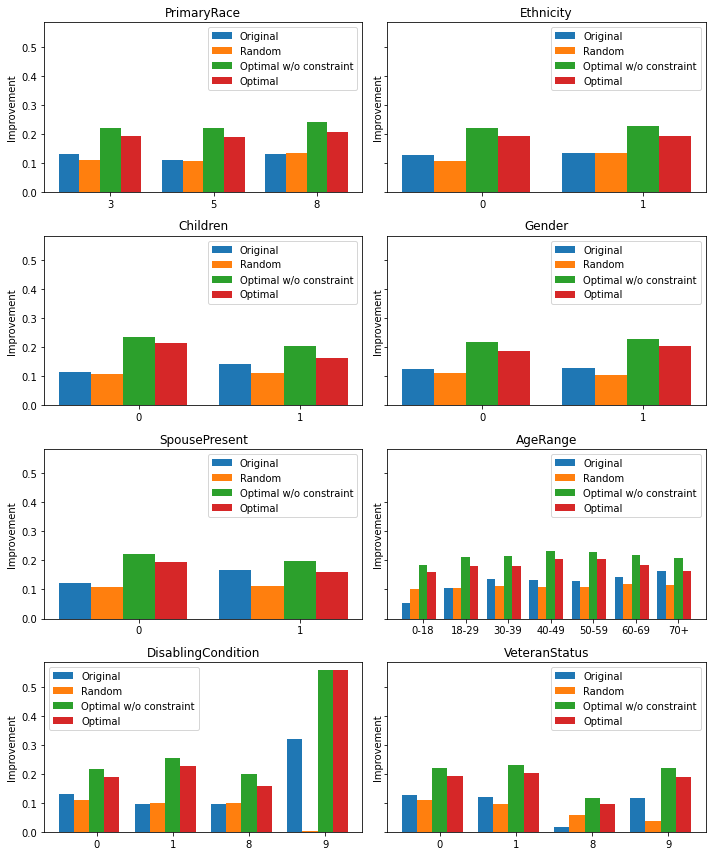

In [ ]:
plot_improvment(df,sensitive_list)

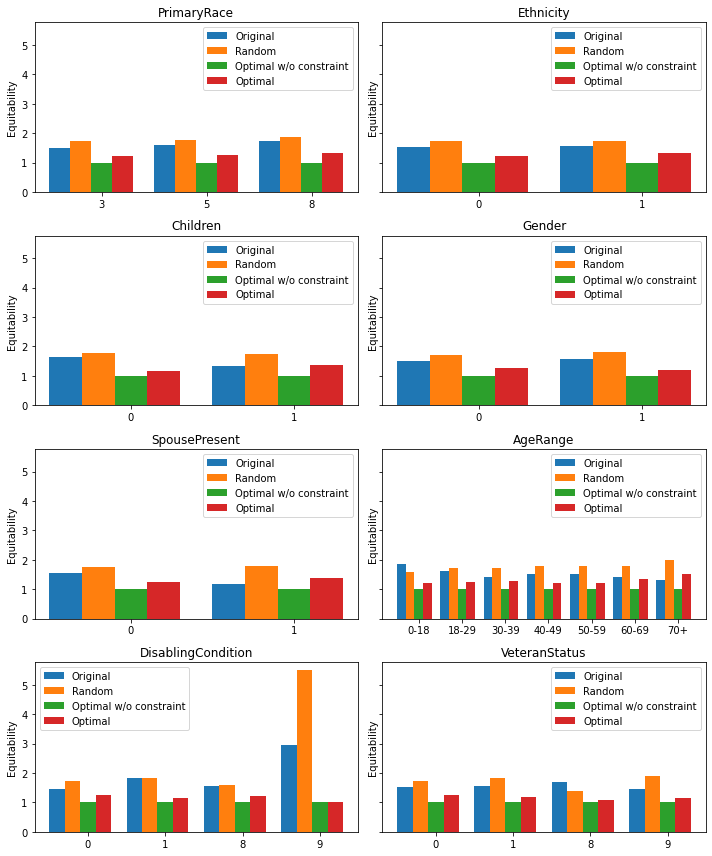

In [ ]:
plot_Equitability(df,sensitive_list)

In [ ]:
df.columns

Index(['HouseholdIdentificationNumber', 'PrimaryRace', 'Ethnicity',
       'DisablingCondition', 'VeteranStatus', 'Children', 'Age',
       'SpousePresent', 'Gender', 'Original', 'ES', 'TH', 'RRH', 'Prev',
       'Outcome', 'AgeRange', 'random', 'P_random', 'Equitability_random',
       'Improvement_random', 'P_true', 'Equitability_true', 'Improvement_true',
       'Optimal', 'ProOptimal', 'Equitability_optimal', 'Improvement_optimal',
       'P_OptimalConst', 'OptimalConst', 'Equitability_constraint',
       'Improvement_constraint'],
      dtype='object')

     |████████████████████████████████| 9.5MB 437kB/s 
     |████████████████████████████████| 256kB 45.7MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 163kB 47.3MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-

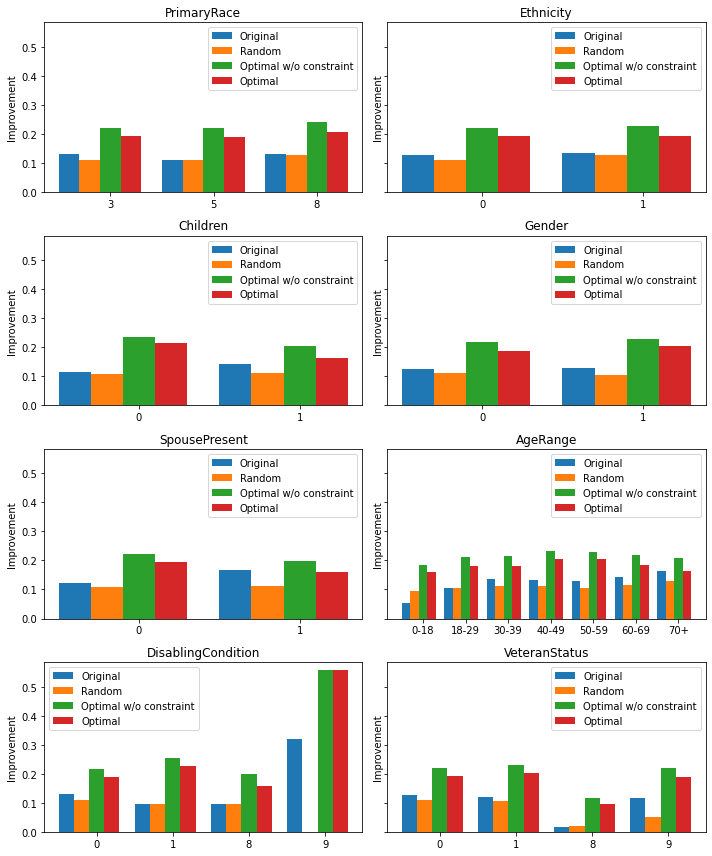

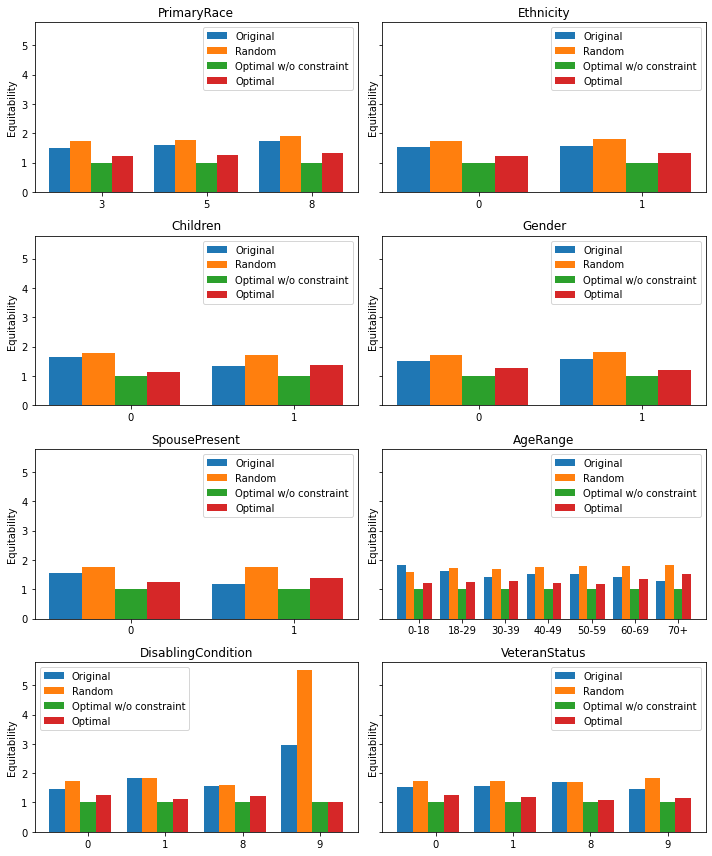

Index(['HouseholdIdentificationNumber', 'PrimaryRace', 'Ethnicity',
       'DisablingCondition', 'VeteranStatus', 'Children', 'Age',
       'SpousePresent', 'Gender', 'Original', 'ES', 'TH', 'RRH', 'Prev',
       'Outcome', 'AgeRange', 'random', 'P_random', 'Equitability_random',
       'Improvement_random', 'P_true', 'Equitability_true', 'Improvement_true',
       'P_optimal', 'ProOptimal', 'Equitability_optimal',
       'Improvement_optimal', 'P_OptimalConst', 'OptimalConst',
       'Equitability_constraint', 'Improvement_constraint',
       'Assignment_random', 'Assignment_true', 'Assignment_optimal',
       'Assignment_optimal_const'],
      dtype='object')

In [1]:
# -*- coding: utf-8 -*-
"""RandomASsignmentW/O Constraint.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1NYSab9CBjbyUq252zHEM-zWDztLcButE
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
from pyomo.environ import *
from pyomo.opt import SolverFactory

"""# Load data"""

df=pd.read_csv('/content/drive/MyDrive/github_OOSProbs_dat_0601520_withID_withSensitiveFeatures.csv')

"""#Preprocessing data"""

df=df.drop(columns='Unnamed: 0')
bins = [0,18, 30, 40, 50, 60, 70, 120]
labels = ['0-18','18-29', '30-39', '40-49', '50-59', '60-69', '70+']
df['AgeRange'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
df['Children'] = df['Children'].mask(df['Children'] > 1, 1)
df['PrimaryRace'] = df['PrimaryRace'].mask(df['PrimaryRace'] < 5, 3)
df['PrimaryRace'] = df['PrimaryRace'].mask(df['PrimaryRace'] > 7, 8)
df['Ethnicity'] = df['Ethnicity'].mask(df['Ethnicity'] > 0, 1)

import random
foo = df.Original.unique().tolist()
temp = [random.randrange(0, 4, 1) for i in range(len(df))]
df['random'] = temp

P_rand=[]
for ind,row in df.iterrows():
  temp=row['random']
  if temp==0:
    P_rand.append(row['ES'])
  elif temp==1:
    P_rand.append(row['Prev']) 
  elif temp==2:
    P_rand.append(row['RRH'])        
  else:
    P_rand.append(row['TH'])  

df['P_random'] = P_rand

# Functions for estimating equitability and improvement
def estimate_equitability(data,P):
  equitibility=[]
  improvment =[]
  for ind,row in data.iterrows():
    mi=min(row[['ES','TH',	'RRH','Prev']])
    e = row[P]/mi
    ma=max(row[['ES','TH',	'RRH','Prev']])
    i = ma-row[P]
    equitibility.append(e)
    improvment.append(i)
  return equitibility,improvment  

def create_group_df(df,x):
  temp=df.groupby(by=x).mean().reset_index()
  tempImprov = temp[[ x,'Improvement_true','Improvement_random', 
        'Improvement_optimal', 'Improvement_constraint','Equitability_true','Equitability_random','Equitability_optimal','Equitability_constraint']]
  return tempImprov      

def find_allocation(temp1,P_col_name):
  P_rand=[]
  for ind,row in temp1.iterrows():
    temp=row[P_col_name]
    if temp==row['ES']:
      P_rand.append("ES")
    elif temp==row['Prev']:
      P_rand.append('Prev') 
    elif temp==row['RRH']:
      P_rand.append('RRH')        
    else:
      P_rand.append('TH') 
  return P_rand

"""### Random Allocation"""

el,im = estimate_equitability(df,'P_random')
df['Equitability_random'] = el
df['Improvement_random'] = im

"""### Original Allocation"""

allocation =[]
for ind,row in df.iterrows():
  temp=row['Original']
  allocation.append(row[temp])
df['P_true']=allocation

el,im = estimate_equitability(df,'P_true')
df['Equitability_true'] = el
df['Improvement_true'] = im

A = df[['ES', 'Prev', 'RRH', 'TH']].values
model = ConcreteModel()
model.Agents = range(len(A))
model.Objects = range(len(A.T))
model.x = Var( model.Agents, model.Objects,bounds=(0.0,1.0) )
model.y = Var( model.Agents, within=Binary )

#Objective
model.obj = Objective(expr = sum(A[n,m]*model.x[n,m] for n in model.Agents for m in model.Objects),sense=minimize )

###Constraints
model.single_x = ConstraintList()
for m in model.Objects:
  model.single_x.add(sum( model.x[n,m] for n in model.Agents ) >=1 )

for m in model.Agents:
  model.single_x.add(sum( model.x[m,n] for n in model.Objects ) == 1.0 )

# create a solver
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

# solve
solver.solve(model)
a=dict()
for n in model.Agents:
  a[n]= []
  for m in model.Objects:
    a[n].append(value(model.x[n,m])*A[n,m])

cost_mat = pd.DataFrame.from_dict(a).T
df['P_optimal'] = cost_mat[[0, 1,2,3]].max(axis=1)
df['ProOptimal'] = cost_mat[[0, 1,2,3]].idxmax(axis=1)

eq1,im1=estimate_equitability(df,'P_optimal')
df['Equitability_optimal'] = eq1
df['Improvement_optimal'] = im1

temp=df.groupby('Original').count()
Capacity=temp.Outcome.unique()
temp

A = df[['ES', 'Prev', 'RRH', 'TH']].values
model = ConcreteModel()
model.Agents = range(len(A))
model.Objects = range(len(A.T))
model.x = Var( model.Agents, model.Objects,bounds=(0.0,1.0) )
model.y = Var( model.Agents, within=Binary )

#Objective
model.obj = Objective(expr = sum(A[n,m]*model.x[n,m] for n in model.Agents for m in model.Objects),sense=minimize )

###Constraints
model.single_x = ConstraintList()
for m in model.Objects:
  model.single_x.add(sum( model.x[n,m] for n in model.Agents ) ==Capacity[m] )

for m in model.Agents:
  model.single_x.add(sum( model.x[m,n] for n in model.Objects ) == 1.0 )

# create a solver
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

# solve
solver.solve(model)
a=dict()
for n in model.Agents:
  a[n]= []
  for m in model.Objects:
    a[n].append(value(model.x[n,m])*A[n,m])

cost_mat = pd.DataFrame.from_dict(a).T
df['P_OptimalConst'] = cost_mat[[0, 1,2,3]].max(axis=1)
df['OptimalConst'] = cost_mat[[0, 1,2,3]].idxmax(axis=1)

eq2,im2=estimate_equitability(df,'P_OptimalConst')
df['Equitability_constraint'] = eq2
df['Improvement_constraint'] = im2

df.head()

df['Assignment_random'] = find_allocation(df,'P_random') 
df['Assignment_true'] = find_allocation(df,'P_true') 
df['Assignment_optimal'] = find_allocation(df,'P_optimal') 
df['Assignment_optimal_const'] = find_allocation(df,'P_OptimalConst')

temp1=df[['HouseholdIdentificationNumber', 'PrimaryRace', 'Ethnicity',
       'DisablingCondition', 'VeteranStatus', 'Children', 'Age',
       'SpousePresent', 'Gender', 'Original', 'ES', 'TH', 'RRH', 'Prev',
       'Outcome', 'AgeRange', 'P_random','Assignment_random', 'P_true',  'Assignment_true','P_optimal','Assignment_optimal',
       'P_OptimalConst','Assignment_optimal_const']]

# temp1

# temp1.to_csv("Dataset_with_assignment_all_homelessness.csv",index=False)

"""### Plotting graph functions"""

def plot_improvment(df,sensitive_list):
    
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots(figsize=(10, 12), nrows=int(len(sensitive_list)/2), ncols=2, sharey=True)
 
    count =0
    for s in sensitive_list:
      new = create_group_df(df,s)
      
      labels = new[s].values
      original = new.Improvement_true.values
      random = new.Improvement_random.values
      optimal = new.Improvement_optimal.values
      constraint = new.Improvement_constraint.values
      x = np.arange(len(labels))  # the label locations
      col = count % 2
      row = count // 2

      rects0 = ax[row][col].bar(x - 0.4, original, width, label='Original')
      rects1 = ax[row][col].bar(x - 0.2, random, width, label='Random')
      rects2 = ax[row][col].bar(x, optimal, width, label='Optimal w/o constraint')
      rects3 = ax[row][col].bar(x + 0.2, constraint, width, label='Optimal')
    # Add some text for labels, title and custom x-axis tick labels, etc.
      ax[row][col].set_ylabel('Improvement')
      ax[row][col].set_title(s)
      ax[row][col].set_xticks(x)
      ax[row][col].set_xticklabels(labels)
      ax[row][col].legend()
      count=count+1

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)
    fig.tight_layout()
    plt.savefig('disparate_allocation_improvment.pdf',dpi=200)

    plt.show()

def plot_Equitability(df,sensitive_list):
    
    width = 0.2  # the width of the bars
    fig, ax = plt.subplots(figsize=(10, 12), nrows=int(len(sensitive_list)/2), ncols=2, sharey=True)
 
    count =0
    for s in sensitive_list:
      new = create_group_df(df,s)
      
      labels = new[s].values
      original = new.Equitability_true.values
      random = new.Equitability_random.values
      optimal = new.Equitability_optimal.values
      constraint = new.Equitability_constraint.values
      x = np.arange(len(labels))  # the label locations
      col = count % 2
      row = count // 2

      rects0 = ax[row][col].bar(x - 0.4, original, width, label='Original')
      rects1 = ax[row][col].bar(x - 0.2, random, width, label='Random')
      rects2 = ax[row][col].bar(x, optimal, width, label='Optimal w/o constraint')
      rects3 = ax[row][col].bar(x + 0.2, constraint, width, label='Optimal')
    # Add some text for labels, title and custom x-axis tick labels, etc.
      ax[row][col].set_ylabel('Equitability')
      ax[row][col].set_title(s)
      ax[row][col].set_xticks(x)
      ax[row][col].set_xticklabels(labels)
      ax[row][col].legend()
      count=count+1

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)
    fig.tight_layout()
    plt.savefig('disparate_allocation_equitability.pdf',dpi=200)

    plt.show()

"""### Plot Disparate Impact"""

sensitive_list = ['PrimaryRace','Ethnicity', 'Children', 'Gender','SpousePresent','AgeRange','DisablingCondition', 'VeteranStatus']

plot_improvment(df,sensitive_list)

plot_Equitability(df,sensitive_list)

df.columns

